In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import imutils

## Tạo bg


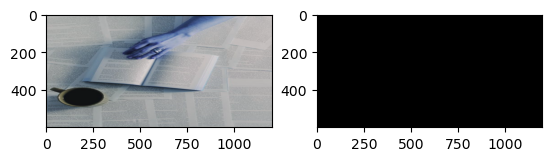

In [2]:
bg = cv2.imread(r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg")
bg = cv2.resize(bg, (1200,600))
h, w, _ = bg.shape

black_bg = np.zeros((600, 1200, 3))
# print(black_bg.shape)

plt.subplot(1,2,1)
plt.imshow(bg)

plt.subplot(1,2,2)
plt.imshow(black_bg)

## Load data_CCCD


360 212


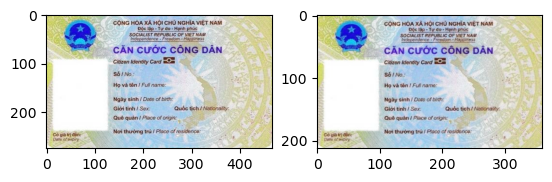

In [3]:
img = cv2.imread(r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\codes\abc.jpg")
h_, w_, _ = img.shape
plt.subplot(1,2,1)
plt.imshow(img)

w_new = int(w*0.3)
h_new = int(h_*(w_new/w_))
print(w_new, h_new)

out_auto = cv2.resize(img, (w_new, h_new) )
h_, w_, _ = out_auto.shape
plt.subplot(1,2,2)
plt.imshow(out_auto)

In [7]:
x_min = int(w*0.4)
y_min = int(h*0.4)
x_max = int(w*0.6)
y_max = int(h*0.6)

x1 = np.random.randint(x_min, x_max)
y1 = np.random.randint(y_min, y_max)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


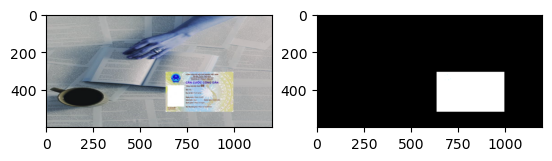

In [8]:
bg[y1:y1+h_ , x1:x1+w_] = out_auto
plt.subplot(1,2,1)
plt.imshow(bg)

black_bg[y1:y1+h_ , x1:x1+w_] = out_auto
plt.subplot(1,2,2)
plt.imshow(black_bg)

In [9]:
def rotate(image, angle, center = None, scale = 1):
    (h, w) = image.shape[:2]
    if center is None:
        center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-10


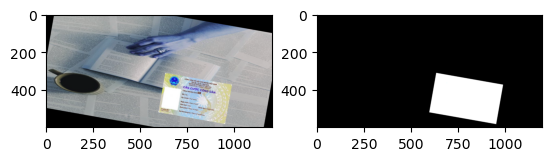

In [10]:
angle = np.random.randint(-15,15)
print(angle)

out_bg = rotate(bg, angle)
h,w,_ = out_bg.shape
plt.subplot(1,2,1)
plt.imshow(out_bg)


out_bg_black = rotate(black_bg, angle)
plt.subplot(1,2,2)
plt.imshow(out_bg_black)

In [11]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    warped = cv2.resize(warped, (1000, 600))
    return tl, tr, br, bl, warped

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


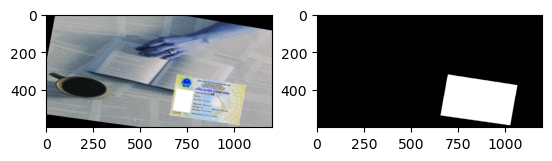

In [12]:
flexible = np.random.uniform(0.85,0.95)

input_pts = np.float32([[0, 0],[w*flexible, 0],[w*flexible, h],[0, h*flexible]])

output_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])

M = cv2.getPerspectiveTransform(input_pts,output_pts)

out1 = cv2.warpPerspective(out_bg.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
plt.subplot(1,2,1)
plt.imshow(out1)


out2 = cv2.warpPerspective(out_bg_black.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
plt.subplot(1,2,2)
plt.imshow(out2)

In [13]:
def order_points2(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform2(image, pts):

    rect = order_points2(pts)
    (tl, tr, br, bl) = rect
    return tl, tr, br, bl

def preprocess2(img):
    img = img.astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.dilate(gray,kernel,iterations = 3)
    gau = cv2.GaussianBlur(erosion, (5, 5), 0)
    edged = cv2.Canny(gau, 150, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            break

    tl, tr, br, bl = four_point_transform2(img.copy(), screenCnt.reshape(4, 2))
    return tl, tr, br, bl

tl, tr, br, bl = preprocess2(out2)
print(tl, tr, br, bl)

[689. 316.] [1068.  372.] [1031.  595.] [651. 543.]


In [14]:
tl = [int(num) for num in tl]
tr = [int(num) for num in tr]
bl = [int(num) for num in bl]
br = [int(num) for num in br]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


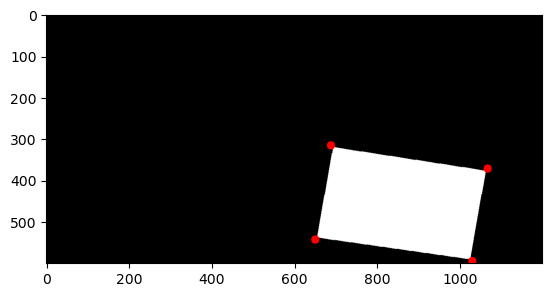

In [15]:
b = cv2.circle(out2.copy(), tl, 10, (255,0,0), -1)
b = cv2.circle(b.copy(), tr, 10, (255,0,0), -1)
b = cv2.circle(b.copy(), bl, 10, (255,0,0), -1)
b = cv2.circle(b.copy(), br, 10, (255,0,0), -1)

plt.imshow(b)

In [16]:
abc = []
abc.append(tl)
abc.append(tr)
abc.append(br)
abc.append(bl)
abc

[[689, 316], [1068, 372], [1031, 595], [651, 543]]

In [17]:
import csv
path = "bau1.jpg"
points = [[530, 333], [897, 273], [915, 489], [551, 552]]
csv_filename = 'points.csv'

# Open the CSV file in write mode
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the flattened list of coordinates as a single row
    writer.writerow([path] +[coord for point in abc for coord in point])